# Tabla de resultados
1. Lectura y todos los subresultados

In [1]:
## Get current work directory to load all the custom modules
from pathlib import Path
import sys
BASE_DIR = Path().absolute().resolve(strict=True).parent
if str(BASE_DIR) not in sys.path:
    sys.path.append(str(BASE_DIR))

In [2]:
DATA_PATH = os.path.join(BASE_DIR, 'data', 'gruas')
print(DATA_PATH)

/workspace/Externos/TimeSeries/BenchMark/data/gruas


In [3]:
import datetime as dt
import pandas as pd
import numpy as np
import glob

># 1. Lectura y Formateo de datos

In [4]:
csv_paths1 = glob.glob(os.path.join(DATA_PATH + "/result/**/", '*.csv'))
csv_paths2 = glob.glob(os.path.join(DATA_PATH + "/result/**/**/", '*.csv'))
csv_paths = csv_paths1 + csv_paths2

### MSE - tabla de resultados

In [5]:
# Hyperparameters by model
for i, csv_result in enumerate(csv_paths):
    result = pd.read_csv(csv_result, usecols=['idArticulo', 'hyper', 'model'])
    model_name = result.model.sample().tolist()[0]
    result.drop(['model'], axis=1, inplace=True)
    result.columns = ['idArticulo', model_name]
    if i == 0:
        data_hyper = result
    else:
        data_hyper = pd.merge(data_hyper, result, on='idArticulo', how='outer')
data_hyper = data_hyper.fillna(1e2)
data_hyper = data_hyper.set_index('idArticulo')
data_hyper.head()

,ARIMA,LR,DL,DT,XGB
idArticulo,,,,,
bateriascanrec,"{'ar': 2, 'ii': 0, 'ma': 2}",{'n_lags': 5},"{'n_lags': 12, 'random_state': 1458, 'optimize...","{'n_lags': 3, 'max_depth': 4, 'random_state': ...","{'n_lags': 3, 'max_depth': 2, 'random_state': ..."
filtrodepresio,"{'ar': 3, 'ii': 0, 'ma': 2}",{'n_lags': 2},"{'n_lags': 7, 'random_state': 2564, 'optimizer...","{'n_lags': 8, 'max_depth': 8, 'random_state': ...","{'n_lags': 6, 'max_depth': 3, 'random_state': ..."
filtroderetorn,"{'ar': 5, 'ii': 2, 'ma': 2}",100.0,"{'n_lags': 2, 'random_state': 2845, 'optimizer...","{'n_lags': 7, 'max_depth': 6, 'random_state': ...","{'n_lags': 6, 'max_depth': 5, 'random_state': ..."
soport,"{'ar': 2, 'ii': 1, 'ma': 0}",{'n_lags': 2},"{'n_lags': 7, 'random_state': 1396, 'optimizer...","{'n_lags': 10, 'max_depth': 9, 'random_state':...","{'n_lags': 5, 'max_depth': 6, 'random_state': ..."
tuerc,"{'ar': 4, 'ii': 0, 'ma': 1}",100.0,"{'n_lags': 2, 'random_state': 733, 'optimizer'...","{'n_lags': 9, 'max_depth': 6, 'random_state': ...","{'n_lags': 4, 'max_depth': 4, 'random_state': ..."


In [6]:
# MSE by model
for i, csv_result in enumerate(csv_paths):
    result = pd.read_csv(csv_result, usecols=['idArticulo', 'mse_test', 'model'])
    model_name = result.model.sample().tolist()[0]
    result.drop(['model'], axis=1, inplace=True)
    result.columns = ['idArticulo', model_name]
    if i == 0:
        data = result
    else:
        data = pd.merge(data, result, on='idArticulo', how='outer')
data = data.fillna(1e2)
data = data.set_index('idArticulo')
data = np.sqrt(data) ## aplicando la raiz cuadrada para pasar de mse a rmse
data.head()

,ARIMA,LR,DL,DT,XGB
idArticulo,,,,,
bateriascanrec,0.519132,0.474695,0.321613,1.732953,1.088756
filtrodepresio,0.341912,1.223695,1.440567,0.363342,0.265604
filtroderetorn,0.634310,10.000000,0.676337,2.959394,1.382989
soport,0.651111,0.585923,0.585229,0.797444,0.542330
tuerc,0.640297,10.000000,0.851998,1.755610,1.082545


In [7]:
columns = data.columns.tolist()
min_mse = data.min(axis=1).tolist()

def set_model(x, columns, hyper):
    index = x.tolist().index(x.min())
    hyper = hyper.loc[x.name, columns[index]]
    return pd.Series(index=['model', 'rmse', 'hyper'], data=[columns[index],x.min(), hyper])
print("="*20 + " RESUMEN RMSE " + "="*20)
hyper_model = data.apply(set_model, args=(columns, data_hyper ), axis=1)
data = data.join(hyper_model)
data = data.sort_values(['rmse'], ascending=True)
data.style.background_gradient(cmap='Blues')


==================== RESUMEN RMSE ====================


,ARIMA,LR,DL,DT,XGB,model,rmse,hyper
idArticulo,,,,,,,,
filtrodepresio,0.341912,1.223695,1.440567,0.363342,0.265604,XGB,0.265604,"{'n_lags': 6, 'max_depth': 3, 'random_state': 2184, 'gamma': 0.9615805068917203, 'n_estimators': 2}"
bateriascanrec,0.519132,0.474695,0.321613,1.732953,1.088756,DL,0.321613,"{'n_lags': 12, 'random_state': 1458, 'optimizer': 'RMSprop', 'learning_rate': 0.0001, 'n_epochs': 150}"
filtrodeair,10.000000,1.345567,10.000000,10.000000,0.330044,XGB,0.330044,"{'n_lags': 5, 'max_depth': 4, 'random_state': 1202, 'gamma': 0.5849827587465187, 'n_estimators': 5}"
soport,0.651111,0.585923,0.585229,0.797444,0.542330,XGB,0.542330,"{'n_lags': 5, 'max_depth': 6, 'random_state': 1653, 'gamma': 0.58033015370564, 'n_estimators': 10}"
arandel,10.000000,0.555849,0.702926,0.686216,0.844690,LR,0.555849,{'n_lags': 5}
filtroderetorn,0.634310,10.000000,0.676337,2.959394,1.382989,ARIMA,0.634310,"{'ar': 5, 'ii': 2, 'ma': 2}"
tuerc,0.640297,10.000000,0.851998,1.755610,1.082545,ARIMA,0.640297,"{'ar': 4, 'ii': 0, 'ma': 1}"
pern,10.000000,0.917013,0.975997,0.765848,1.049003,DT,0.765848,"{'n_lags': 10, 'max_depth': 8, 'random_state': 1748, 'ccp_alpha': 0.03564701729313271}"


## Autocorrelación por gráfica ACF

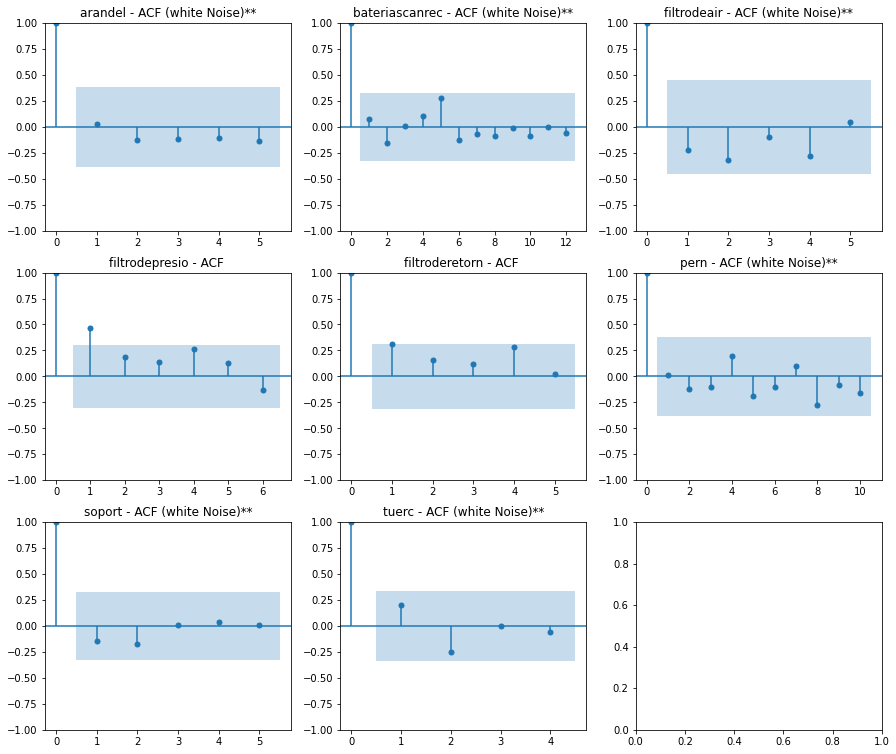

In [8]:
from modulos.arima.gruas.general import format_timeseries
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from modulos.LR.gruas.generals import make_timeserie_arima
import statsmodels.api as sm
import json

data_ts = pd.read_csv(os.path.join(DATA_PATH, 'producto.csv'), parse_dates=['Periodo'])
df_time = format_timeseries(data_ts)
data["trustworthy"] = None
articulos = df_time.columns.tolist()
fig, axs = plt.subplots(round(len(articulos)/3), 3, figsize=(15, 13))
axs = axs.flatten()
for idx, articulo in enumerate(articulos):
    ts, _ = make_timeserie_arima(df_time[articulo].copy())
    nlags = json.loads(data.loc[articulo,"hyper"].replace("'","\""))
    
    n_lags = nlags.get('n_lags',None)
    if n_lags is None:
        n_lags = nlags.get('ar',None)
    val = sm.stats.acorr_ljungbox(ts, lags=[n_lags],)
    wn = val['lb_pvalue'].tolist()[0] < 0.05 # if True then this is not a white noise serie
    tag = "(white Noise)**" if not wn else ""
    data.loc[articulo, "trustworthy"] = wn
    plot_pacf(ts, lags=n_lags, method='ywm', title=str(articulo) + " - ACF " + tag, ax=axs[idx])

In [9]:
data.to_csv(os.path.join(DATA_PATH, 'resumen_rmse.csv'))

In [10]:
data

,ARIMA,LR,DL,DT,XGB,model,rmse,hyper,trustworthy
idArticulo,,,,,,,,,
filtrodepresio,0.341912,1.223695,1.440567,0.363342,0.265604,XGB,0.265604,"{'n_lags': 6, 'max_depth': 3, 'random_state': ...",True
bateriascanrec,0.519132,0.474695,0.321613,1.732953,1.088756,DL,0.321613,"{'n_lags': 12, 'random_state': 1458, 'optimize...",False
filtrodeair,10.000000,1.345567,10.000000,10.000000,0.330044,XGB,0.330044,"{'n_lags': 5, 'max_depth': 4, 'random_state': ...",False
soport,0.651111,0.585923,0.585229,0.797444,0.542330,XGB,0.542330,"{'n_lags': 5, 'max_depth': 6, 'random_state': ...",False
arandel,10.000000,0.555849,0.702926,0.686216,0.844690,LR,0.555849,{'n_lags': 5},False
filtroderetorn,0.634310,10.000000,0.676337,2.959394,1.382989,ARIMA,0.634310,"{'ar': 5, 'ii': 2, 'ma': 2}",True
tuerc,0.640297,10.000000,0.851998,1.755610,1.082545,ARIMA,0.640297,"{'ar': 4, 'ii': 0, 'ma': 1}",False
pern,10.000000,0.917013,0.975997,0.765848,1.049003,DT,0.765848,"{'n_lags': 10, 'max_depth': 8, 'random_state':...",False
